<a href="https://colab.research.google.com/github/valntinaf/tensor-internals/blob/main/Numpy_vs_TF_vs_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import torch
from datetime import datetime
from collections import defaultdict
from functools import wraps
import matplotlib.pyplot as plt

In [ ]:
tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17055839527062583870
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7407047922238084204
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
torch.cuda.is_available()

True

In [ ]:
histogram = defaultdict(lambda: defaultdict(list))

In [ ]:
def averaged_dict():
  averaged_dict = defaultdict(lambda: defaultdict(float))
  for tag, values in histogram.items():
    for size, values_ in values.items():
      averaged_dict[tag][size] = np.average(histogram[tag][size])
  return averaged_dict

def plot_histogram(averaged_dict):
  # (75,165,201),
  colors = [(75,165,201), (243,204,104), (228,75,43)]
  i = 0
  fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
  for tag, values in averaged_dict.items():
    print(values.keys())
    plt.plot(list(values.values()), c=(colors[i][0]/255, colors[i][1]/255, colors[i][2]/255), label=tag)
    i += 1
    plt.legend()
  plt.xlabel("Size in 10*y")
  plt.ylabel("Time in milliseconds")
  plt.grid()
  plt.show()

In [ ]:
def wrap_time(*args, **kwargs):
  def inner(func):
    tag = kwargs['tag']
    size = kwargs['size']
    @wraps(func)
    def wrapper(*args, **kwargs):
      time_a = datetime.now()
      result = func(*args, **kwargs)
      time_b = datetime.now()
      total_time = time_b - time_a
      # print("Time ellapsed in {}: {}".format(tag, total_time))
      if tag:
        if size:
          histogram[tag][size].append(float(total_time.microseconds))  
        else:
          histogram[tag][1].append(float(total_time.microseconds))
    return wrapper       
  return inner


In [ ]:
def instantiate_all(size=1):
  a = [i for i in range(size)]
  @wrap_time(tag="numpy_instantiation", size=size)
  def instantiate_numpy():
    np.array(a)

  @wrap_time(tag="tf_instantiation", size=size)
  def instantiate_tf():
    a_tf = tf.constant(a)

  @wrap_time(tag="torch_instantiation", size=size)
  def instantiate_tr():
    a_tr = torch.Tensor(a)

  instantiate_numpy()
  instantiate_tf()
  instantiate_tr()

for i in range(3):
  for j in range(1, 400000, 1000):
    instantiate_all(size=10*j)

KeyboardInterrupt: ignored

In [ ]:
def random_all(size=1):
  @wrap_time(tag="numpy_random", size=size)
  def random_numpy():
    np.random.rand(size,0)

  @wrap_time(tag="tf_random", size=size)
  def random_tf():
    a_tf = tf.random.normal((size,0))

  @wrap_time(tag="torch_random", size=size)
  def random_tr():
    a_tr = torch.rand((size,0))

  random_numpy()
  random_tf()
  random_tr()

for i in range(3):
  for j in range(1, 25000, 100):
    random_all(size=10*j)

In [ ]:
def multiply_all(size=1):
  @wrap_time(tag="numpy_multiplication", size=size)
  def multiply_numpy():
    a_np = np.random.rand(size, 1)
    b_np = np.random.rand(1, size)
    c_np = a_np*b_np
    assert c_np.shape == (size, size)

  @wrap_time(tag="tf_multiplication", size=size)
  def multiply_tf():
    a_tf = tf.random.uniform((size, 1))
    b_tf = tf.random.uniform((1, size))
    c_tf = tf.matmul(a_tf, b_tf)
    assert tf.executing_eagerly()
    assert c_tf.shape == (size, size)

  @wrap_time(tag="torch_multiplication", size=size)
  def multiply_tr():
    a_tr = torch.rand((size, 1))
    b_tr = torch.rand((1, size))
    c_tr = torch.matmul(a_tr, b_tr)
    assert c_tr.shape == (size, size)

  # multiply_numpy()
  multiply_tf()
  multiply_tr()

for i in range(3):
  for j in range(1, 5000, 100):
    multiply_all(size=10*j)

In [ ]:
def multiply_all_gpu(size=1):
  @wrap_time(tag="numpy_multiplication_gpu", size=size)
  def multiply_numpy():
    a_np = np.random.rand(1, size)
    b_np = np.random.rand(size, 1)
    c_np=a_np*b_np

  @wrap_time(tag="tf_multiplication_gpu", size=size)
  def multiply_tf():
    gpu = tf.test.gpu_device_name()
    with tf.device('/gpu:0'):
      a_tf = tf.random.uniform((size, 1))
      b_tf = tf.random.uniform((1, size))
      assert a_tf.device.endswith("GPU:0")
      assert b_tf.device.endswith("GPU:0")
      c_tf=tf.matmul(a_tf, b_tf)

  @wrap_time(tag="torch_multiplication_gpu", size=size)
  def multiply_tr():
    a_tr = torch.rand((size, 1))
    a_tr = a_tr.to("cuda:0")
    assert str(a_tr.device) == "cuda:0"
    b_tr = torch.rand((1, size))
    b_tr = b_tr.to("cuda:0")
    assert str(b_tr.device) == "cuda:0"
    c_tr=torch.matmul(a_tr, b_tr)
    assert str(c_tr.device) == "cuda:0"

  multiply_numpy()
  multiply_tf()
  multiply_tr()

for i in range(3):
  for j in range(1, 20000, 50):
    multiply_all_gpu(size=j)

In [ ]:
histogram = defaultdict(lambda: defaultdict(list))

dict_keys([1, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951, 1001, 1051, 1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601, 1651, 1701, 1751, 1801, 1851, 1901, 1951, 2001, 2051, 2101, 2151, 2201, 2251, 2301, 2351, 2401, 2451, 2501, 2551, 2601, 2651, 2701, 2751, 2801, 2851, 2901, 2951, 3001, 3051, 3101, 3151, 3201, 3251, 3301, 3351, 3401, 3451, 3501, 3551, 3601, 3651, 3701, 3751, 3801, 3851, 3901, 3951, 4001, 4051, 4101, 4151, 4201, 4251, 4301, 4351, 4401, 4451, 4501, 4551, 4601, 4651, 4701, 4751, 4801, 4851, 4901, 4951, 5001, 5051, 5101, 5151, 5201, 5251, 5301, 5351, 5401, 5451, 5501, 5551, 5601, 5651, 5701, 5751, 5801, 5851, 5901, 5951, 6001, 6051, 6101, 6151, 6201, 6251, 6301, 6351, 6401, 6451, 6501, 6551, 6601, 6651, 6701, 6751, 6801, 6851, 6901, 6951, 7001, 7051, 7101, 7151, 7201, 7251, 7301, 7351, 7401, 7451, 7501, 7551, 7601, 7651, 7701, 7751, 7801, 7851, 7901, 7951, 8001, 8051, 8101, 8151, 8201, 8251, 8301, 8351, 8401

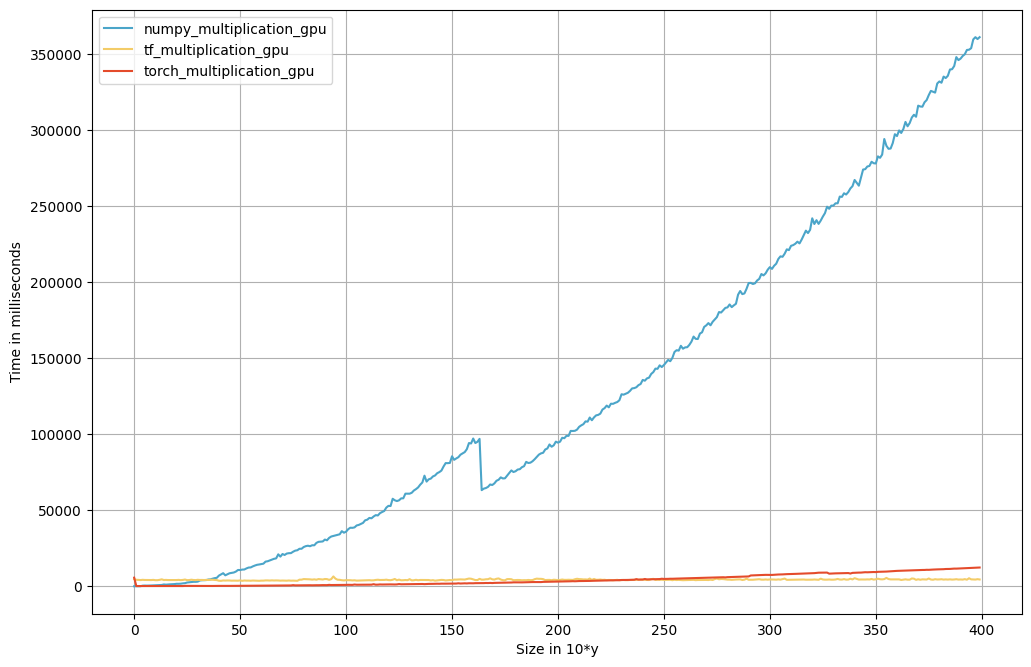

In [ ]:
a = averaged_dict()
plot_histogram(a)